# Testing Super-resolution Model

Super-resolution prediction and metrification 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio
import pandas as pd
import tifffile
import cv2

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

# Set the upsampling scale and depth of trained model
scale = 2
depth = 32

### Importa Images

In [6]:
def import_images(folder_path):
    files_in_folder = sorted(os.listdir(folder_path))
    images = [file for file in files_in_folder if os.path.isfile(os.path.join(folder_path, file))]
    image_objects = []
    for image_name in images:
        full_path = os.path.join(folder_path, image_name)
        image = np.array(tifffile.imread(full_path))

        image_objects.append(image)
    image_objects = np.array(image_objects)

    return image_objects

lr_test_paste = "test/lr"
hr_test_paste = "test/hr"

lr_test = import_images(lr_test_paste)
hr_test = import_images(hr_test_paste)

In [18]:
# As pixels in MudrockZoom images are between 0-254 (from aquisition), downsampled images needs to be normalized 
min_val = 0
max_val = 254

downsampled_test_paste = 'dadownsampled/test/'
downsampled_lr_test = import_images(downsampled_test_paste)
downsampled_lr_test = cv2.normalize(downsampled_lr_test, None, min_val, max_val, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

print("downsampled_lr_train.shape:", downsampled_lr_test.shape)

(255, dtype('uint8'), (16, 768, 1024))

### Instanciar modelo

In [14]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True) 
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)

    # for 4x upsacaling, add these layers
    #x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    #x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 1))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(1, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

model = make_model(num_filters=64, num_of_residual_blocks=depth)

In [16]:
model.load_weights('models/real.h5')

### Criar imagens super-resolvidas

In [ ]:
num_images = lr_test.shape[0]
destination_folder = f'SR_images/realModel'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
sr_images_list = []
for i in range(num_images):
    lr_image = tf.expand_dims(lr_test[i], axis=0)
    sr_image = model(lr_image)
    sr_image = tf.squeeze(sr_image)
    sr_image = sr_image.numpy()
    sr_image = cv2.normalize(sr_image, None, alpha=0, beta=254, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    sr_images_list.append(sr_image)

    i_str = str(i).zfill(2)
    full_path = os.path.join(destination_folder, f'sr_{i_str}.tif')
    sr_image_pil = np.array(sr_image.astype(np.uint8))
    imageio.imwrite(full_path, sr_image_pil)

    print(f'Image saved at: {full_path}')

sr_images_array = np.array(sr_images_list)


Exibir comparação de imagens super-resolvidas e de alta resolução

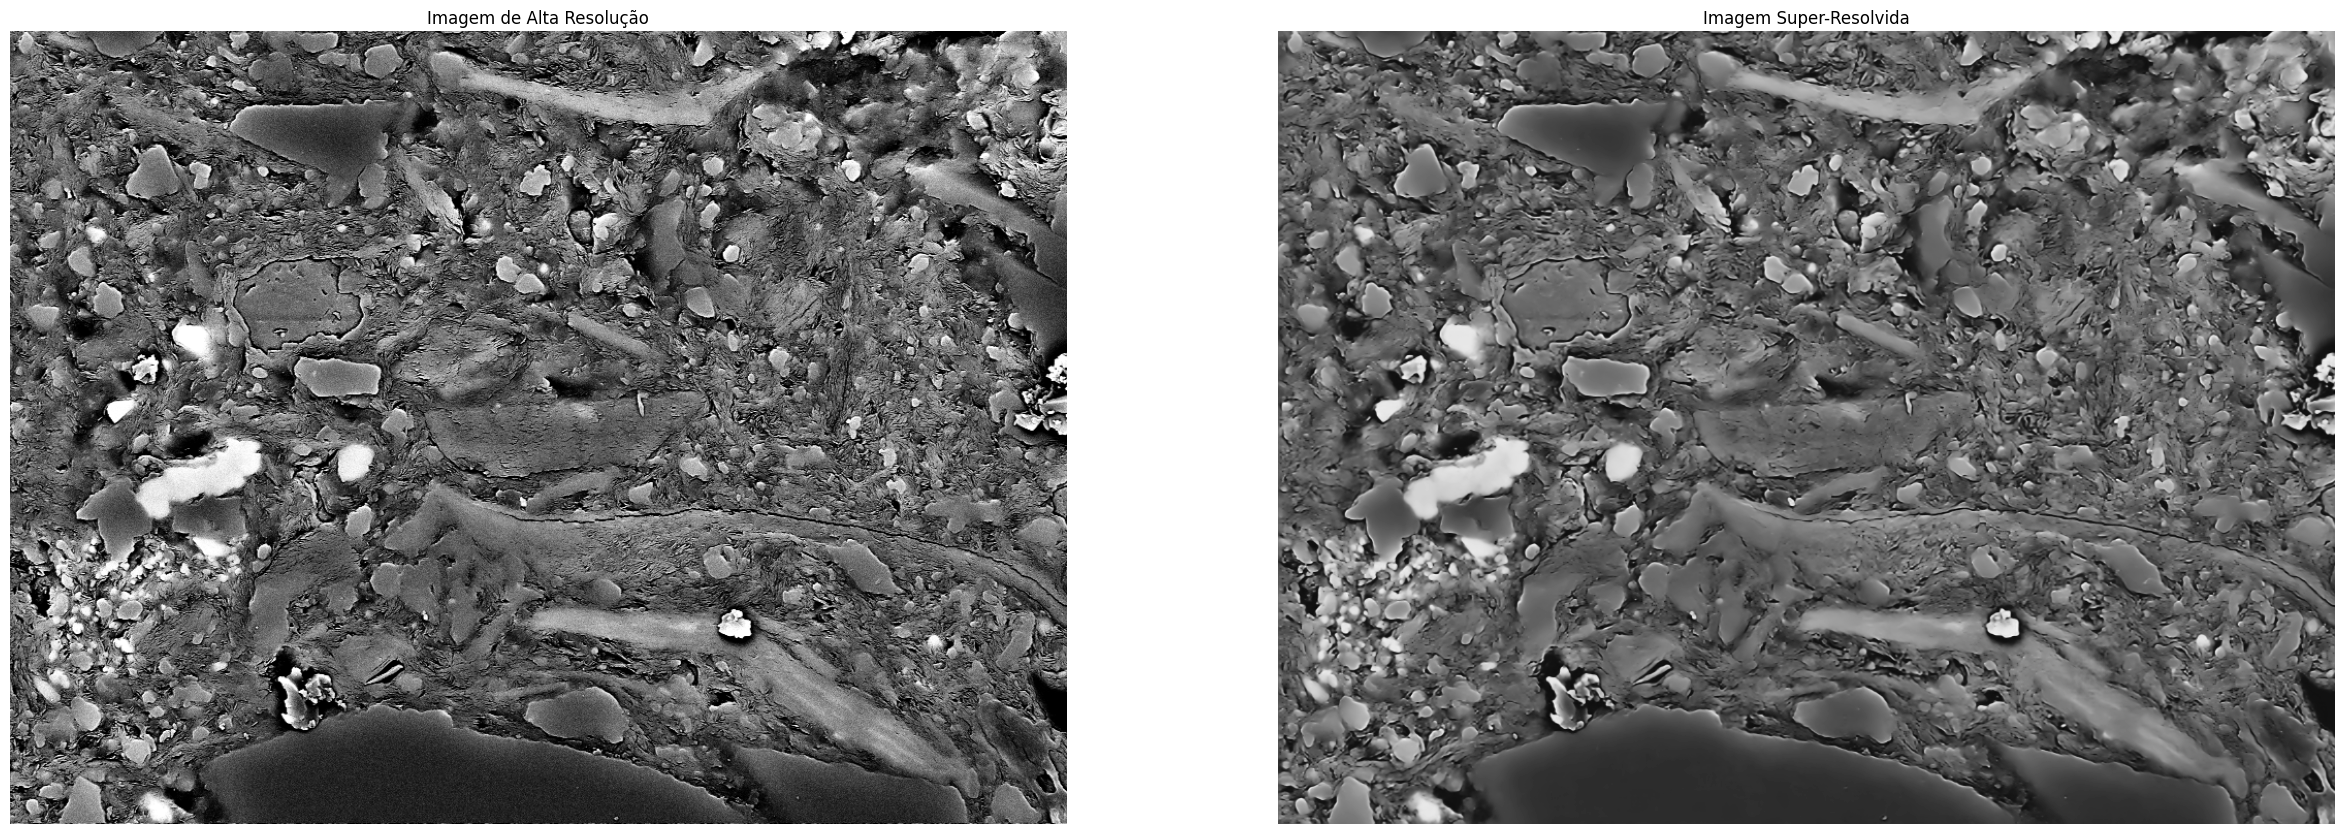

In [ ]:
random_number = np.random.randint(hr_test.shape[0])

hr_random = hr_test[random_number]
sr_random = sr_images_array[random_number]

plt.figure(figsize=(30, 15))

plt.subplot(1, 2, 1)
plt.imshow(hr_random, cmap='gray')
plt.title('HR image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sr_random, cmap='gray')
plt.title('SR image')
plt.axis('off')

plt.show()

### Quantify results

In [24]:
real_paste = 'SR_images/realModel'
hibrid_paste = 'SR_images/hybridModel'
downsample_paste = 'SR_images/downsampledModel'
RBdownsampled_paste = 'SR_images/RBdownsampledModel'

real_SR = import_images(real_paste)
hibrid_SR = import_images(hibrid_paste)
downsample_SR = import_images(downsample_paste)
RBdownsampled_SR = import_images(RBdownsampled_paste)

In [25]:
import csv
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def save_metrics_to_csv(hr_images, sr_images, model, scale, degraded, csv_path):
    open_mode = 'w' if not os.path.exists(csv_path) else 'a'

    with open(csv_path, open_mode, newline='') as csvfile:
        columns = ['sample', 'model', 'degraded', 'scale', 'PSNR', 'SSIM']
        csv_writer = csv.DictWriter(csvfile, fieldnames=columns)

        if open_mode == 'w':
            csv_writer.writeheader()

        def calculate_and_write_metrics(hr_images, sr_images):
            for i, (hr_image, sr_image) in enumerate(zip(hr_images, sr_images), start=1):
                hr_image_float = hr_image.astype(np.float32) / 255.0
                sr_image_float = sr_image.astype(np.float32) / 255.0

                psnr_value = psnr(hr_image, sr_image, data_range=254)
                ssim_value = ssim(hr_image_float, sr_image_float, channel_axis=True)

                csv_writer.writerow({'sample': i, 'model': model, 'degraded': degraded,
                                     'scale': scale, 'PSNR': psnr_value,
                                     'SSIM': ssim_value})

        calculate_and_write_metrics(hr_images, sr_images)

    print(f'Metrics saved to: {csv_path}')

In [ ]:
# Example of using the save_metricas_csv function
model = 'real'
scale = '2x'
degraded = False
caminho_csv = 'metrics.csv'

save_metrics_to_csv(hr_test, real_SR, model, scale, degraded, caminho_csv)

Bicubic Interpolation

In [ ]:
import numpy as np
from scipy.ndimage import zoom
scale = 2

sr_bicubic_list =[]
for lr_image in lr_test:
    sr_bicubic = zoom(lr_image, scale, order=3) # order = 3 is bicubic
    sr_bicubic_list.append(sr_bicubic)
sr_bicubic = np.array(sr_bicubic_list)

print("Shape da array sr_bicubic:", sr_bicubic.shape)

In [ ]:
model = 'Bicubic'
scale = '2x'
degraded = False
caminho_csv = 'metrics.csv'

save_metrics_to_csv(hr_test, sr_bicubic, model, scale, degraded, caminho_csv)

### Metrics

In [ ]:
import pandas as pd

caminho_arquivo = 'metrics.csv'
dados = pd.read_csv(caminho_arquivo)
print(dados.head())

In [ ]:
import pandas as pd

grups = dados.groupby(['model'])
stats = ['mean', 'median', 'min', 'max', 'std']
results = grups[['PSNR', 'SSIM']].agg(stats)

results.to_csv('stats.csv', index=True)
print(results)

In [ ]:
transposed = results.transpose()  
print(transposed)
transposed.to_csv('transposedStats.csv', index=True)